## Part 1: Watersheds

We will start by using the watershed algorithm. As you may know, this algorithm is originally designed for 2D images, not 3D volumes. However, if we extend its principles to three dimensions—where intensities can represent porosity, density, or temperature (whichever interpretation is most intuitive to you)—we can perform watershed segmentation in 3D.

### 1.1 Watersheds

Initially, we will perform watershed segmentation without much complexity, and our seeds will be generated automatically. The main goal of this first part is to identify the boundaries.

As you may recall, one of the easiest ways to extract edges in 2D is by using Sobel filters. However, these are designed for images and not for volumes. While we could apply them slice by slice, that would ignore important adjacent information in the third dimension. Instead, we will compute edge information using the **morphological gradient**. This operator, although originally defined for 2D, ca


In [2]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
import nibabel as nib
from skimage.measure import label
from matplotlib import pyplot as plt
from skimage.segmentation import watershed
from skimage.morphology import dilation, erosion, opening, closing, h_minima, ball, disk, cube

import warnings
try:
    import cupy as cp
except ImportError:
    warnings.warn("CuPy not found. Falling back to NumPy.")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6916\2011950993.py:15: UserWarning: CuPy not found. Falling back to NumPy.
  warnings.warn("CuPy not found. Falling back to NumPy.")


In [4]:
vol1 = nib.load(os.path.join('DB', 'train', 'volume_1.nii.gz')).get_fdata()
seg1=nib.load(os.path.join('DB', 'train', 'segmentation_1.nii.gz')).get_fdata()

def morph_gradient(gray_img,EE):
    dil = dilation(gray_img, EE)
    ero = erosion(gray_img, EE)

    result = dil-ero #Variable que tendrá la imagen resultante
    return result

element = ball(5) #Variable que tendrá un elemento estructurante de esfera de radio 5
borders = morph_gradient(vol1,element)#Variable que tendrá los bordes del volumen 1 de entrenamiento 

In [5]:
assert borders.shape == (512,512,123), f'Alteró el tamaño de su volumen, debe ser (512,512,123) no {borders.shape}'
assert len(element.shape)==3,f'su elemento estructurante debería tener 3 dimensiones, no {len(element.shape)}'
assert element.shape==(11,11,11),f'su elemento estructurante está definido erroneamente su tamaño debe ser (512,512,2), no {element.shape}'
assert len(np.unique(element))==2, f'su elemento estructurante solo debería tener 2 valores, no {len(np.unique(element))}'
assert np.min(borders)>=0 and np.max(borders)<=1 ,f'el rango de su borde debería estar entre 0 y 1, no entre {np.min(borders)} y {np.max(borders)}'

Ahora que ya tenemos el **gradiente morfológico** sabemos que este al final será nuestra imagen sobre la que vamos a usar watersheds. Para esto entonces use la funcion de skimage.segmentation(https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) para realizar este procedimiento sobre el gradiente que ya calculó.

In [9]:
# Aplicar el algoritmo de watershed sin marcadores explícitos
watersheds_org = watershed(borders, markers=None, watershed_line=True) #variable que tendrá el resultado de hacer watersheds sin marcadores

In [10]:
assert watersheds_org.shape == (512,512,123), f'Alteró el tamaño de su volumen de watersheds, debe ser (512,512,123) no {watersheds_org.shape}'
assert watersheds_org.dtype=='int32' ,f'su volumen debería ser de tipo int 32 no {watersheds_org.dtype}'

Visualice su volumen en almenos 2 cortes para ver lo que está sucediendo. Ademas, revise cuantos segmentos hay en total en el volumen.

>- **Consejo:** Puede utilizar la función np.unique() y la función len() para contar el número de segmentos.

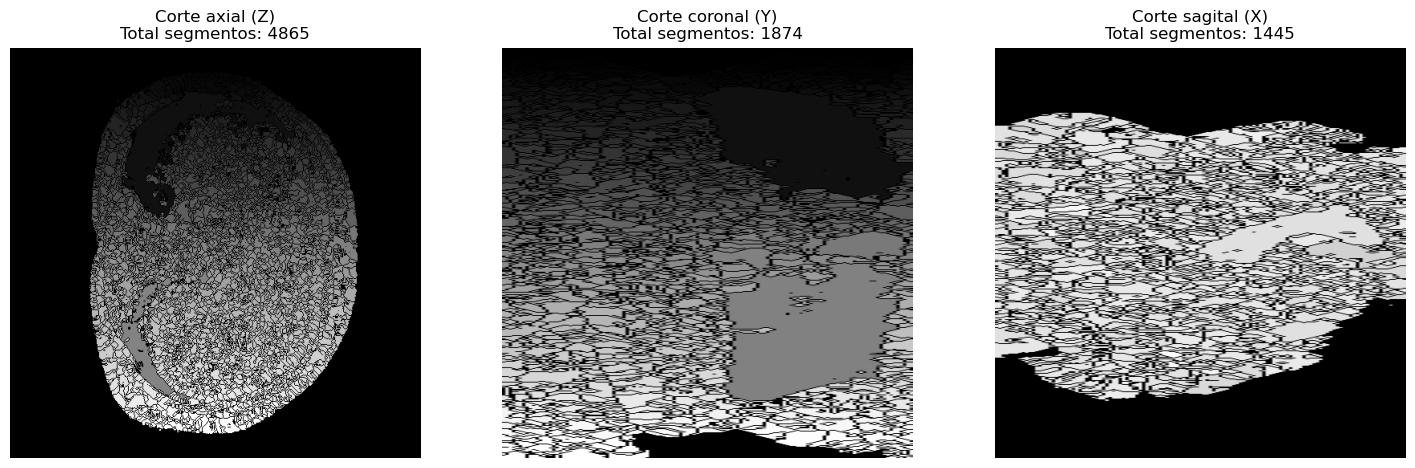

Total de segmentos en el volumen: 107441
Total de segmentos en el corte axial (Z): 4865
Total de segmentos en el corte coronal (Y): 1874
Total de segmentos en el corte sagital (X): 1445


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Visualización de tres cortes del volumen segmentado
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

# Selección de cortes en diferentes planos
z_slice = vol1.shape[2] // 2  # Vista axial
y_slice = vol1.shape[1] // 2  # Vista coronal
x_slice = vol1.shape[0] // 2  # Vista sagital

# Obtener segmentos únicos en cada corte
segments_axial = np.unique(watersheds_org[:, :, z_slice])
segments_coronal = np.unique(watersheds_org[:, y_slice, :])
segments_sagital = np.unique(watersheds_org[x_slice, :, :])

# Mostrar el corte axial (Z)
axes[0].imshow(watersheds_org[:, :, z_slice], cmap="gray")  
axes[0].set_title(f"Corte axial (Z)\nTotal segmentos: {len(segments_axial)}") 
axes[0].axis("off")  

# Mostrar el corte coronal (Y) asegurando que sea cuadrado
axes[1].imshow(watersheds_org[:, y_slice, :], cmap="gray") 
axes[1].set_aspect(watersheds_org.shape[2] / watersheds_org.shape[0])
axes[1].set_title(f"Corte coronal (Y)\nTotal segmentos: {len(segments_coronal)}")  
axes[1].axis("off") 

# Mostrar el corte sagital (X)
axes[2].imshow(watersheds_org[x_slice, :, :], cmap="gray")  
axes[2].set_aspect(watersheds_org.shape[2] / watersheds_org.shape[1])
axes[2].set_title(f"Corte sagital (X)\nTotal segmentos: {len(segments_sagital)}")  
axes[2].axis("off")  

# Mostrar la figura
plt.show()

# Conteo del número total de segmentos en el volumen
segment_labels = np.unique(watersheds_org)  # Obtener etiquetas únicas de segmentos
num_segments = len(segment_labels)  # Contar cuántas etiquetas únicas hay
print(f"Total de segmentos en el volumen: {num_segments}")  
print(f"Total de segmentos en el corte axial (Z): {len(segments_axial)}")  
print(f"Total de segmentos en el corte coronal (Y): {len(segments_coronal)}")  
print(f"Total de segmentos en el corte sagital (X): {len(segments_sagital)}")  


In [16]:
# Calcular los h-minimos en el gradiente morfológico
h_factor = 0.05  # Factor ajustable según la sobresegmentación
h_value = (np.max(borders) - np.min(borders)) * h_factor
minima = h_minima(borders, h_value)#Variable que contendrá los h-minimos

In [17]:
assert minima.shape == (512,512,123), f'Alteró el tamaño de su volumen de minimos, debe ser (512,512,123) no {minima.shape}'
assert minima.dtype=='uint8' ,f'su volumen debería ser de tipo uint8 no {minima.dtype}'
assert len(np.unique(minima))==2,f'sus minimos solo deberían tener 2 valores, no {len(np.unique(minima))}'

In [22]:
# Generar los marcadores a partir de los h-mínimos
markers = label(minima) # Variable que tendrá los marcadores con sus respectivos labels

# Aplicar Watershed con los marcadores
watersheds_h = watershed(borders, markers=markers, watershed_line=False) #variable que tendrá el resultado de hacer watersheds

# Contar el número de segmentos resultantes
num_segments = len(np.unique(watersheds_h)) - 1 
print(f"Número de segmentos después de Watershed con h-minima: {num_segments}")

Número de segmentos después de Watershed con h-minima: 2327


In [24]:
assert markers.shape == (512,512,123), f'Alteró el tamaño de su volumen de minimos, debe ser (512,512,123) no {markers.shape}'
assert markers.dtype=='int64' ,f'su volumen de marcadores debería ser de tipo int64 no {markers.dtype}'
assert watersheds_h.shape == (512,512,123), f'Alteró el tamaño de su volumen de watersheds, debe ser (512,512,123) no {watersheds_h.shape}'
assert watersheds_h.dtype=='int64' ,f'su volumen de watersheds debería ser de tipo int32 no {watersheds_h.dtype}'
assert len(np.unique(markers))-1==len(np.unique(watersheds_h)),f'sus minimos y su resultado de watersheds no tienen los mismos valores {len(np.unique(markers))} y{len(np.unique(watersheds_h))}'

Otra vez, visualice su volumen en almenos 2 cortes para ver lo que está sucediendo

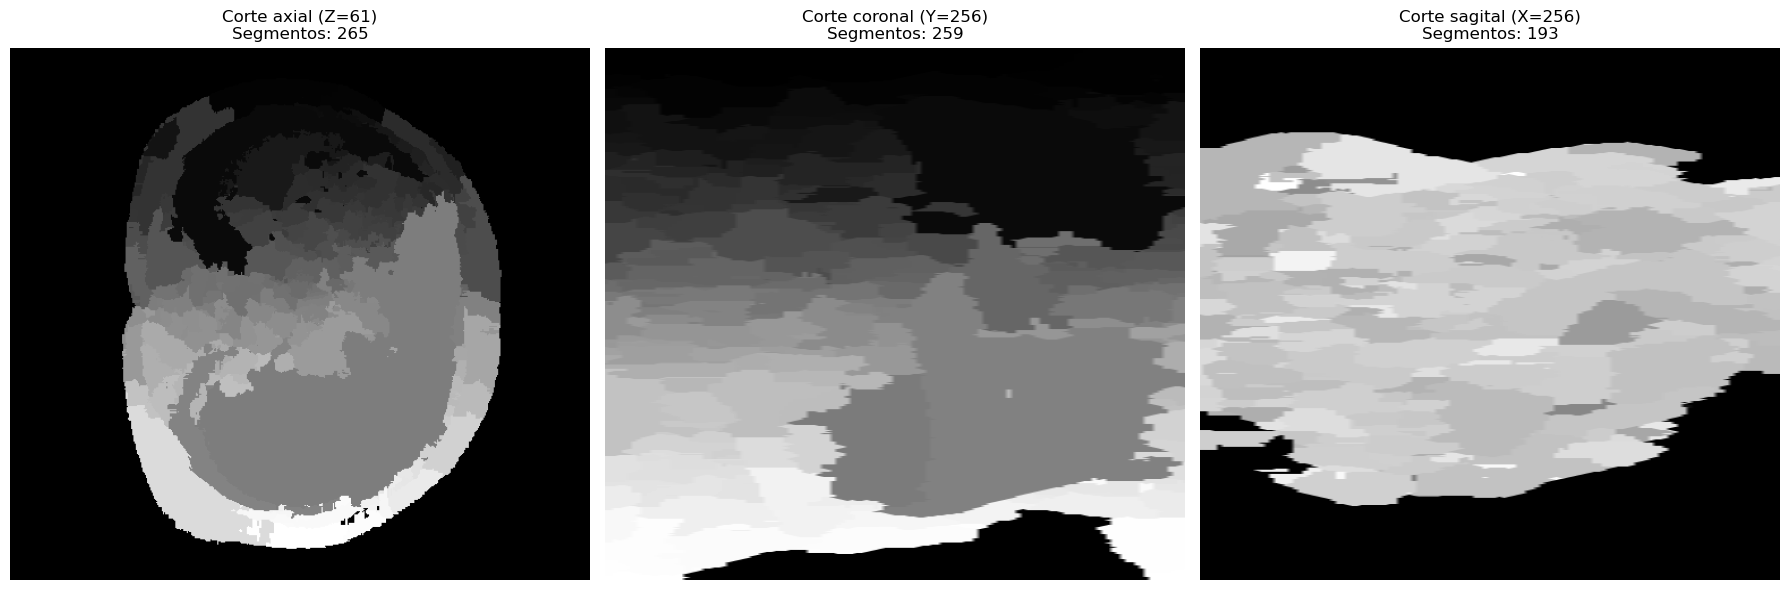

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

# Seleccionar los cortes
z_slice = watersheds_h.shape[2] // 2  # Corte axial
y_slice = watersheds_h.shape[1] // 2  # Corte coronal
x_slice = watersheds_h.shape[0] // 2  # Corte sagital

# Obtener las imágenes de los cortes
axial = watersheds_h[:, :, z_slice]
coronal = watersheds_h[:, y_slice, :]
sagital = watersheds_h[x_slice, :, :]

# Encontrar el tamaño máximo para unificar la visualización
max_dim = max(axial.shape[0], axial.shape[1], coronal.shape[0], coronal.shape[1], sagital.shape[0], sagital.shape[1])

def resize_image(img, target_size):
    """ Escala la imagen para que ocupe todo el cuadrado sin deformarse. """
    zoom_factors = (target_size / img.shape[0], target_size / img.shape[1])
    return zoom(img, zoom_factors, order=1)  # Interpolación bilineal

# Redimensionar las imágenes para que todas sean del mismo tamaño
axial_resized = resize_image(axial, max_dim)
coronal_resized = resize_image(coronal, max_dim)
sagital_resized = resize_image(sagital, max_dim)

# Contar el número de segmentos en cada corte
num_segments_axial = len(np.unique(axial)) - 1
num_segments_coronal = len(np.unique(coronal)) - 1
num_segments_sagital = len(np.unique(sagital)) - 1

# Visualización de los cortes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mostrar los cortes con los títulos correspondientes
axes[0].imshow(axial_resized, cmap="gray", aspect="auto")
axes[0].set_title(f"Corte axial (Z={z_slice})\nSegmentos: {num_segments_axial}")
axes[0].axis("off")

axes[1].imshow(coronal_resized, cmap="gray", aspect="auto")
axes[1].set_title(f"Corte coronal (Y={y_slice})\nSegmentos: {num_segments_coronal}")
axes[1].axis("off")

axes[2].imshow(sagital_resized, cmap="gray", aspect="auto")
axes[2].set_title(f"Corte sagital (X={x_slice})\nSegmentos: {num_segments_sagital}")
axes[2].axis("off")

# Mostrar la figura
plt.tight_layout()
plt.show()


In [31]:
class MyClass:
    def __init__(self):
        self.attribute = "This is an attribute"
    
    def method(self):
        print("This is my method.")
        print("Let's print the attribute\n",self.attribute)

Luego de crear la clase, vamos a crear una instancia de la clase, es decir, un objeto. Para eso podemos llamar la Clase anterior de la siguiente manera:

In [34]:
# Dentro del parentesis no ponemos nada, pero si el método __init__ tuvieras
# otros parámetros los tendríamos que poner dentro de este
variable = MyClass()
print(variable)

Así mismo, podemos acceder a los atributos y métodos de un objeto de la siguiente manera:

In [37]:
print(variable.attribute, "\n")
# Nuevamente acá no ponemos nada dentro de los paréntesis, pero si fuera necesario
# se podría
variable.method()

This is an attribute 

This is my method.
Let's print the attribute
 This is an attribute


In [40]:
class NNClassifier:
    def __init__(self):
        self.vectores=None #atributo del vector de características
        self.etiquetas=None #atributo del vector de etiquetas
        
    def fit(self, X, Y):
        '''
        :param X: Vectores de características
        :param y: Labels de las imagenes
        :return: self (Trained descriptor)
        '''
        if len(X) == 0 or len(Y) == 0:
            raise ValueError("Los datos de entrenamiento están vacíos. Revisa la función que genera los datos.")
    
        self.vectores = np.array(X)
        self.etiquetas = np.array(Y)
        return self

        
    def euclidean_distance(self, x1, x2):
        """
        Calcula la distancia euclidiana entre dos vectores.

        :param x1: Primer vector (array de numpy)
        :param x2: Segundo vector (array de numpy)
        :return: Distancia euclidiana entre x1 y x2
        """
        return np.linalg.norm(x1 - x2)

    def predict(self,X):
        '''
        :param X (array): Imagenes a predecir
        :return: Arreglo de etiquetas predichas
        '''
        predict_vector = []  # Lista para almacenar las predicciones

        for x in X:
            # Calcula la distancia a todos los vectores de entrenamiento
            distances = np.array([self.euclidean_distance(x, v) for v in self.vectores])
            # Encuentra el índice del vector más cercano
            nearest_index = np.argmin(distances)
            # Asigna la etiqueta correspondiente
            predict_vector.append(self.etiquetas[nearest_index])

        predict_vector = np.array(predict_vector)
        return predict_vector



In [42]:
train_vector=[[0,0],[0,1],[1,0],[1,1]]
train_labels=[0,0,1,1]
predict=[[0,0.5],[1,0.5],[0.7,0],[0.3,0]]

nn_classifier = NNClassifier()
nn_classifier.fit(train_vector, train_labels)
predict_vector = nn_classifier.predict(predict)

In [44]:
predict_vector

array([0, 1, 1, 0])

In [46]:
assert len(predict_vector)==len(predict)
assert not np.sum(predict_vector-np.array([0,1,1,0])), 'Sus predicciones fueron erroneas'

In [169]:
def voxels_train(fold,bins):
    """Esta función se encarga de extraer los voxels de los volúmenes

    Args:
        fold (str): Fold para escoger volúmenes.
        bins (int): Número de bins en el histograma

    Returns:
        (np.ndarray): Arreglo de histogramas,
        (np.ndarray): Arreglo de etiquetas
    """
    np.random.seed(1)
    
    # Extraer tanto los volúmenes cómo las segmentaciones
    paths_v = glob(os.path.join('DB',fold,'volume*'))
    paths_s = glob(os.path.join('DB',fold,'segmentation*'))
    v=[]
    l=[]
    
    # Recorrer todos los volúmenes
    for i, pv in tqdm(enumerate(paths_v)):
        
        # Abrir volúmenes de entrenamiento y segmentación
        vol = nib.load(pv).get_fdata()
        seg = nib.load(paths_s[i]).get_fdata()>0
        x,y,z=vol.shape
        
        # Este for sirve para extraer los histogramas y etiquetas 100000 voxeles al azar
        for _ in range(100000):
            
            # Elegir la coordenadas 3D al azar
            r1=np.random.randint(10,x-11)
            r2=np.random.randint(10,y-11)
            r3=np.random.randint(10,z-11)
            
            # Obtener la etiqueta
            etiqueta=int(seg[r1,r2,r3])
            
            # Extraer el histograma
            h,_=np.histogram(vol[r1-10:r1+11,r2-10:r2+11,r3-10:r3+11],bins=bins)
            
            # Guardar el histograma y la etiqueta
            v.append(h)
            l.append(etiqueta)
    
    return v, l
            

In [171]:
train_data_total=voxels_train('train',20)

7it [08:28, 72.62s/it]


In [179]:
etiquetas,cuenta=np.unique(train_data_total[1],return_counts=True)
assert np.isclose(np.sum(np.array(train_data_total[1])==1),18233,0.1), f'Debería tener 300 datos positivos en su muestra y tiene {np.sum(np.array(train_data_total[1])==1)}'
assert len(etiquetas)==2, 'Solo deberíamos tener 2 etiquetas en la muestra'
assert np.max(etiquetas)==1 and np.min(etiquetas)==0, 'La maxima etiqueta debe ser 1 y la minima 0'
assert len(train_data_total[0])>3000, f'Su muestra debe tener al menos 3000 datos y tiene {len(train_data_total[0])}'
assert len(train_data_total[0][0])==20, 'Si se hizo un histograma de 20 bins, la dimensión del vector de caracteristicas debe ser 20'

En la siguiente celda está implementada la función de segmentación con componente conexo más grande en 3D

In [183]:
def vol_max_component(volume, max=None, min=None):
    """Esta función realiza la segmentación mediante elemento conexo más grande en 3D

    Args:
        volume (np.ndarray): Volumen a segmentar
        max (float | None): Limite inferior para realizar la segmentación
        min (float | None): Limite superior para realiza la segmentación

    Return:
        (np.ndarray): Volumen segmentado
    """

    # ASegurarnos que al menos se ingrese un valor de corte
    assert (
        max is not None or min is not None
    ), "Debe ingresar al menos un valor de corte"

    # Si se ingresó un valor de corte máximo realizar la umbralización
    # Sino se mantiene un volumen de unos
    segment_vol_max = np.ones_like(volume)
    if max is not None:
        segment_vol_max = (volume < max).astype(int)

    # Si se ingresó un valor de corte mínimo realizar la umbralización
    # Sino se mantiene un volumen de unos
    segment_vol_min = np.ones_like(volume)
    if min is not None:
        segment_vol_min = (volume > min).astype(int)

    # Hallar la intersección entre los dos elementos
    segment_vol = np.logical_and(segment_vol_max, segment_vol_min)

    # Utilizar la función label para hallar los componentes conexos
    segment_vol = label(segment_vol)

    # Contar la cantidad la cantidad de voxeles que hacen parte del elemento conexo más grande
    unique, unique_counts = np.unique(segment_vol, return_counts=True)

    # Encuentra el índice del elemento conexo más grande sin contar el fondo
    arg = np.argmax(unique_counts[1:])

    # Hallar la etiqueta del elemento conexo más grande
    # La suma de uno se debe a que el fondo tiene la etiqueta 0
    label_max = unique[arg + 1]

    # Finalmente, se saca un volumen binario con solo el componente conexo más grande
    segment_vol = (segment_vol == label_max).astype(int)

    return segment_vol

Para evaluar las segmentaciones utilice la función Jaccard_3D que hemos utilizado desde entregas pasadas.

In [186]:
def Jaccard_3D(Im,Gt):
    '''
    :param Im: Volumen de prediccion.
    :param Gt: Segmentacion groundtruth.
    '''
    # Convertir groundtruth en binario (label 1 y 2 se consideran como 1)
    Gt_bin = (Gt > 0).astype(np.uint8)
    Im_bin = (Im > 0).astype(np.uint8)
    
    # Calcular la intersección y la unión
    intersection = np.logical_and(Im_bin, Gt_bin).sum()
    union = np.logical_or(Im_bin, Gt_bin).sum()
    
    # Evitar división por cero
    J = intersection / (union + 1e-6)
    
    return J

El jaccard del volúmen resultante de nuestra segmentación con la función de elemento conexo más grande en 3D es: 0.220


(-0.5, 511.5, 511.5, -0.5)

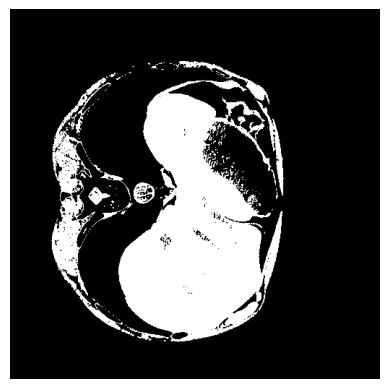

In [188]:
vol_val = nib.load(os.path.join('DB', 'valid', 'volume_34.nii.gz')).get_fdata()
seg_val = (nib.load(os.path.join('DB', 'valid', 'segmentation_34.nii.gz')).get_fdata()>0).astype(np.uint8)

result = vol_max_component(vol_val, 0.95, 0.5)

print(f"El jaccard del volúmen resultante de nuestra segmentación con la función de elemento conexo más grande en 3D es: {Jaccard_3D(result, seg_val):.3f}")
plt.imshow(result[:,:,114], cmap='gray')
plt.axis("off")

In [190]:
print(f"La cantidad de falsos positivos en el volumen segmentado es: {int(np.sum(result - np.logical_and(seg_val, result)))}")
print(f"La cantidad de falsos negativos en el volumen segmentado es: {int(np.sum(seg_val - np.logical_and(seg_val, result)))}")

La cantidad de falsos positivos en el volumen segmentado es: 5140358
La cantidad de falsos negativos en el volumen segmentado es: 6626


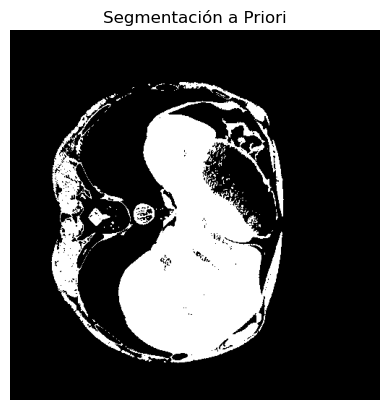

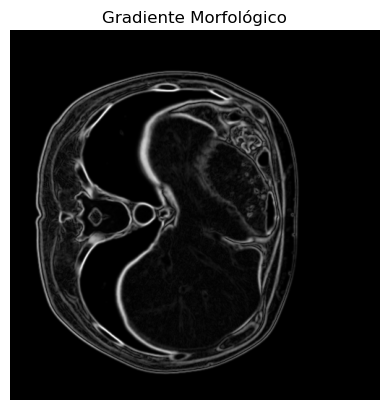

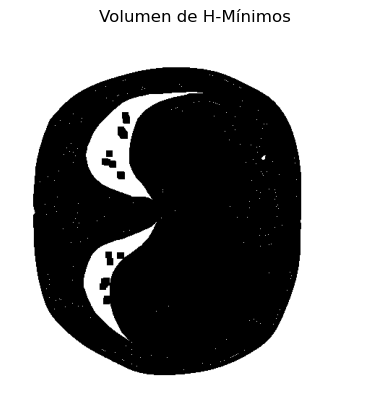

7it [08:38, 74.13s/it]


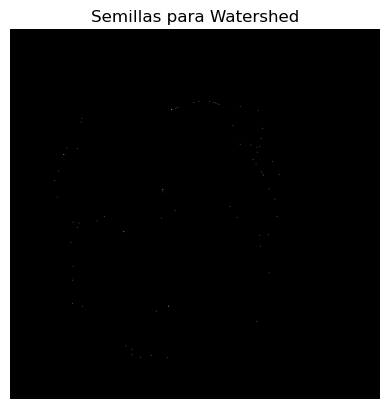

In [193]:
from scipy.ndimage import gaussian_gradient_magnitude
# Generar el volumen de segmentación a priori
seg_priori = vol_max_component(vol_val, max=0.95, min=0.5)

# Mostrar una sección de la segmentación a priori
plt.imshow(seg_priori[:, :, 114], cmap='gray')
plt.axis("off")
plt.title("Segmentación a Priori")
plt.show()

# Calcular el gradiente morfológico usando una aproximación con un filtro Gaussiano
gradiente = gaussian_gradient_magnitude(vol_val, sigma=1)  # sigma=1 suaviza el ruido

# Mostrar una sección del gradiente
plt.imshow(gradiente[:, :, 114], cmap='gray')
plt.axis("off")
plt.title("Gradiente Morfológico")
plt.show()

# Aplicar h-minima para detectar posibles semillas
h_min_vol = h_minima(gradiente, h=0.01)

# Convertir a tipo int para facilitar la segmentación
h_min_vol = h_min_vol.astype(np.uint8)

# Mostrar una sección de los h-mínimos detectados
plt.imshow(h_min_vol[:, :, 114], cmap='gray')
plt.axis("off")
plt.title("Volumen de H-Mínimos")
plt.show()

from scipy.spatial import KDTree
from skimage.segmentation import watershed
from skimage.morphology import ball

# Crear una matriz de semillas con ceros
semillas = np.zeros_like(vol_val, dtype=np.uint8)

# Cargar datos de entrenamiento (histogramas y etiquetas)
train_hist, train_labels = voxels_train('train', bins=20)

# Crear KDTree para buscar el vecino más cercano
tree = KDTree(train_hist)

# Recorrer los voxeles de h-minima
x, y, z = np.where(h_min_vol == 1)  # Coordenadas de h-minima detectadas

for i in range(len(x)):
    r1, r2, r3 = x[i], y[i], z[i]
    
    # Verificar si el voxel pertenece a la segmentación a priori
    if seg_priori[r1, r2, r3] == 1:
        # Extraer el histograma del voxel actual
        hist, _ = np.histogram(vol_val[r1-10:r1+11, r2-10:r2+11, r3-10:r3+11], bins=20)

        # Encontrar el vecino más cercano en el dataset de entrenamiento
        _, index = tree.query(hist)
        etiqueta_predicha = train_labels[index]

        # Si la etiqueta predicha es 1, asignar como semilla positiva (2)
        if etiqueta_predicha == 1:
            semillas[r1, r2, r3] = 2
        # Si la etiqueta predicha es 0, asignar como semilla negativa (1)
        else:
            semillas[r1, r2, r3] = 1

# Mostrar una sección de las semillas generadas
plt.imshow(semillas[:, :, 114], cmap='gray')
plt.axis("off")
plt.title("Semillas para Watershed")
plt.show()

Use la siguiente celda para obtener el volumen de semillas clasificadas.

Para realizar el histograma utilice los mismo parámetros que en la función voxels_train.

In [195]:
def clasificador_nn(hist):
    """Clasifica un histograma usando el vecino más cercano en KDTree"""
    _, index = tree.query(hist)  # Buscar el vecino más cercano en KDTree
    return train_labels[index]   # Retornar la etiqueta correspondiente
negative = 0  # Número de negativos obtenidos
positive = 0  # Número de positivos obtenidos
minima2 = np.zeros_like(vol_val, dtype=np.uint8)  # Volumen de semillas clasificadas

# Parámetros
bins = 20  # Número de bins del histograma

# Listas para almacenar histogramas y etiquetas
histogramas = []
etiquetas = []

# Clasificar semillas y extraer histogramas
for i in range(10, vol_val.shape[0] - 10):
    for j in range(10, vol_val.shape[1] - 10):
        for k in range(10, vol_val.shape[2] - 10):
            if h_min_vol[i, j, k] == 1 and seg_priori[i, j, k] == 1:
                # Extraer vecindad y calcular histograma
                vecindad = vol_val[i-10:i+11, j-10:j+11, k-10:k+11]
                hist, _ = np.histogram(vecindad, bins=bins)

                # Predecir etiqueta con clasificador NN
                etiqueta_predicha = clasificador_nn(hist)

                # Asignar valores en el volumen de semillas clasificadas
                if etiqueta_predicha == 1:
                    minima2[i, j, k] = 2
                    positive += 1
                else:
                    minima2[i, j, k] = 1
                    negative += 1

                # Guardar histograma y etiqueta
                histogramas.append(hist)
                etiquetas.append(etiqueta_predicha)

# Convertir listas a arrays de NumPy
histogramas = np.array(histogramas)
etiquetas = np.array(etiquetas)

print(f"Semillas positivas: {positive}")
print(f"Semillas negativas: {negative}")


Semillas positivas: 207
Semillas negativas: 10794


Visualice sus semillas en el volumen de bordes en ell slice 65. Las semillas son puntos por lo que se puede usar la función [plt.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) para graficarlos.

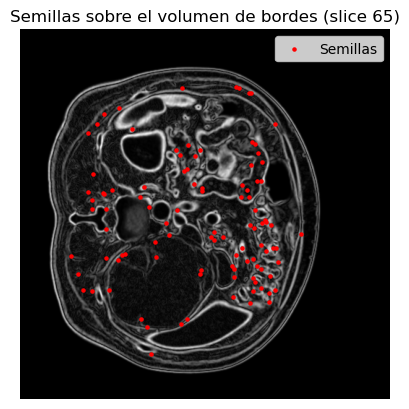

In [199]:
import matplotlib.pyplot as plt

# Obtener las coordenadas de las semillas en el slice 65
x, y = np.where(semillas[:, :, 65] > 0)

# Mostrar el volumen de bordes en el slice 65
plt.imshow(gradiente[:, :, 65], cmap='gray')  # Usamos el gradiente como volumen de bordes
plt.scatter(y, x, c='red', s=5, label="Semillas")  # Dibujar semillas en rojo
plt.axis("off")
plt.legend()
plt.title("Semillas sobre el volumen de bordes (slice 65)")
plt.show()


In [201]:
etiquetas, cantidades= np.unique(minima2,return_counts=True)
assert negative and positive, 'Deben haber más de un positivo y un negativo en sus semillas, de no ser así, intente obtener más minimos con h-minimos bajando el h'
assert len(minima2.shape)==3, 'Las dimensiones del volumen de minima2 deberían ser 3'
assert np.sum(minima2[:,:,65]), 'Las semillas deben estar en el slice 65 axial'
assert len(etiquetas)==3, f'Deberían haber 3 etiquetas diferentes en el volumen de etiquetas clasificadas y son {len(etiquetas)}'
assert np.max(etiquetas)==2, f'El valor de la etiqueta maxima debe ser 2 y es {np.max(etiquetas)}'
assert np.min(etiquetas)==0, f'El valor de la etiqueta minima debe ser 0 y es {np.min(etiquetas)}'
assert cantidades[0]>=1 and cantidades[1]>=1 and cantidades[2]>=1, 'Debería haber al menos una etiqueta de cada una en su volumen'

nn_classifier = NNClassifier()
nn_classifier.fit(train_data_total[0], train_data_total[1])

indicesx,indicesy,indicesz=np.where(minima2==2)
h,_=np.histogram(vol_val[indicesx[0]-10:indicesx[0]+11,indicesy[0]-10:indicesy[0]+11,indicesz[0]-10:indicesz[0]+11],bins=20)
result=nn_classifier.predict([h])
assert result[0]==1

indicesx,indicesy,indicesz=np.where(minima2==1)
h,_=np.histogram(vol_val[indicesx[0]-10:indicesx[0]+11,indicesy[0]-10:indicesy[0]+11,indicesz[0]-10:indicesz[0]+11],bins=20)
result=nn_classifier.predict([h])
assert result[0]==0

Ahora, usando estas semillas, cree 1 volumen segmentado usando watersheds. Use como volumen a segmentar el volumen de gradiente morfológico. Sin embargo, esta vez utilice cómo elemento estructurante una bola de radio 1. Luego de segmentar con watersehds, reste 1 a cada etiqueta.

In [204]:
from scipy.ndimage import gaussian_gradient_magnitude

# Calcular el gradiente morfológico
borders = gaussian_gradient_magnitude(vol_val, sigma=1)  # sigma=1 para suavizar ruido

seg_priori = vol_max_component(vol_val,max=0.92, min=0.8)

In [206]:
from scipy.ndimage import distance_transform_edt
from skimage.morphology import remove_small_objects


#  Mantenemos el h_minima con h=0.01 como requerido
h_min_vol = h_minima(gradiente, h=0.01).astype(np.uint8)

#  Procesamiento más robusto de las semillas
semillas = np.where(semillas > 1, 1, 0).astype(np.uint8)

#  Refinamiento de marcadores con operaciones morfológicas
from skimage.morphology import binary_opening, binary_closing
semillas_refinadas = binary_closing(binary_opening(semillas))

#  Transformada de distancia con ajuste
dist_transform = distance_transform_edt(semillas_refinadas)

#  Watershed con parámetros optimizados
new_segment_vol_gray = watershed(
    borders,
    markers=semillas_refinadas + 5,  # Usamos las semillas refinadas directamente
    mask=seg_priori,
    connectivity=1,  # Mayor conectividad para estructuras 3D
    compactness=0.2  # Menor compactness para formas irregulares
)

# Post-procesamiento más agresivo
new_segment_vol_gray = np.where(new_segment_vol_gray > 0, 1, 0).astype(np.uint8)
new_segment_vol_gray = remove_small_objects(new_segment_vol_gray.astype(bool), min_size=100).astype(np.uint8)


Evalue sus nuevos volumenes segmentados, visualizelos tambien ¿ve alguna diferencia?

El índice de Jaccard para la segmentación con watershed es: 0.651


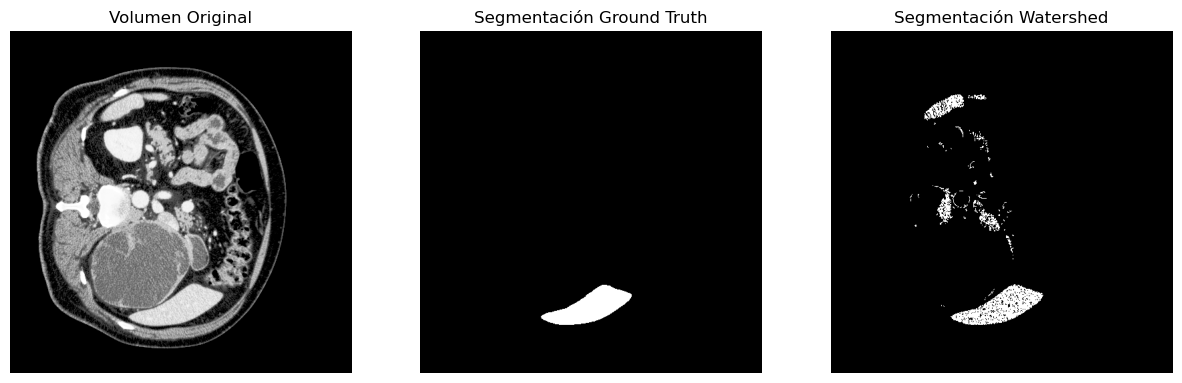

In [209]:
# Calcular el índice de Jaccard entre la nueva segmentación y la segmentación ground truth
jaccard_watershed = Jaccard_3D(new_segment_vol_gray, seg_val>0)

print(f"El índice de Jaccard para la segmentación con watershed es: {jaccard_watershed:.3f}")

#Para visualizar
# Mostrar una sección de la segmentación original vs. watershed
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
axes[0].imshow(vol_val[:, :, 65], cmap='gray')
axes[0].set_title("Volumen Original")
axes[0].axis("off")

# Segmentación Ground Truth
axes[1].imshow(seg_val[:, :, 65], cmap='gray')
axes[1].set_title("Segmentación Ground Truth")
axes[1].axis("off")

# Segmentación con watershed
axes[2].imshow(new_segment_vol_gray[:, :, 65], cmap='gray')
axes[2].set_title("Segmentación Watershed")
axes[2].axis("off")

plt.show()

In [211]:
assert len(np.unique(new_segment_vol_gray))==2, 'Solo debeían haber 2 etiquetas en su volumen de segmentación'
assert np.max(new_segment_vol_gray)==1, 'El maximo de su volumen de segmentación debería ser 1'
assert np.min(new_segment_vol_gray)==0, 'El minimo de su volumen de segmentación debería ser 0'
assert Jaccard_3D(new_segment_vol_gray,seg_val>0)>0.48, 'Su volumen seguramente fue mal segmentado, puede deberse a la clasificación de sus semillas, intente usar un hminima de 0.01'

Para liberar un poco más de espacio antes de seguir con la siguiente función, borraremos algunas variables.

Para eso utilizaremos globals().items() que tendrá las variables globales definidas. Además, utilizaremos la función sys.getsizeof() para obtener el tamaño del objeto. Finalmente, organizaremos este diccionario para obtener las variables que más gasten memoria.

In [214]:
import sys

def memory_usage():
    memory_dict = {}
    for name, var in globals().items():
        memory_dict[name] = sys.getsizeof(var)
    
    return memory_dict
    
memory_dict = memory_usage()
memory_list = sorted(memory_dict.items(), key=lambda item:item[1], reverse=True)

for element in memory_list[:8]:
    print(f"Variable: {element[0]:30} Tamaño: {element[1] / (1024 ** 2)} MB")

# Si hay alguna variable que no vayas a utilizar puedes utilizar del para eliminarla de la siguiente manera
# vol_prueba_liberacion = vol1
# del vol_prueba_liberacion

Variable: borders                        Tamaño: 302.00013732910156 MB
Variable: gradiente                      Tamaño: 302.00013732910156 MB
Variable: dist_transform                 Tamaño: 302.00013732910156 MB
Variable: seg1                           Tamaño: 246.00013732910156 MB
Variable: markers                        Tamaño: 246.00013732910156 MB
Variable: watersheds_h                   Tamaño: 246.00013732910156 MB
Variable: seg_priori                     Tamaño: 151.00013732910156 MB
Variable: watersheds_org                 Tamaño: 123.00013732910156 MB


In [264]:
from scipy.ndimage import gaussian_gradient_magnitude, distance_transform_edt
from skimage.morphology import ball, binary_opening, binary_closing, erosion, remove_small_objects
from skimage.segmentation import watershed

# Elemento estructurante para operaciones morfológicas
selem = ball(1.7)

# Parámetros de experimentación
definir_compactness = 0.2
h_val = 0.08
umbral_max = 0.92
umbral_min = 0.69
from skimage.morphology import dilation, closing
from skimage.morphology import ball as ball_skimage

def preprocesamiento_total(vol):
    st_e = ball_skimage(3)
    vol_ero = erosion(vol, st_e)
    vol_dil = dilation(vol_ero, st_e)
    vol_pre = vol - vol_dil
    mask = (vol_pre >= 0.1) & (vol_pre <= 1)
    vol_pre_total = np.where(mask, 0, vol)
    return vol_pre_total

def postprocesamiento_total(vol):
    vol_bin = (vol > 0).astype(np.uint8)
    vol_ero = erosion(vol_bin, ball_skimage(0))

    from skimage.morphology import reconstruction
    marker = vol_ero
    mask = vol_bin
    vol_post = reconstruction(marker, mask, method='dilation')
    vol_post = closing(vol_post, ball_skimage(0))
    return vol_post.astype(np.uint8)


# Función final de segmentación
def Segmentacion(vol):
    # Preprocesamiento total
    vol_pre = preprocesamiento_total(vol)

    # 1. Calcular el gradiente morfológico
    gradiente = gaussian_gradient_magnitude(vol_pre, sigma=1)

    # 2. Generar volumen de segmentación a priori
    seg_priori = vol_max_component(vol_pre, max=umbral_max, min=umbral_min)

    # 3. Obtener semillas con h-minima
    h_min_vol = h_minima(gradiente, h=h_val).astype(np.uint8)
    semillas = (h_min_vol > 0).astype(np.uint8)

    # 4. Refinamiento de semillas
    semillas = binary_closing(binary_opening(semillas, selem), selem)
    semillas = erosion(semillas, selem).astype(np.uint8)

    # 5. Watershed con parámetros optimizados
    markers = semillas + 5
    borders = gradiente.astype(np.float64)
    seg_total = watershed(
        borders,
        markers=markers.astype(np.int32),
        mask=seg_priori.astype(bool),
        connectivity=1,
        compactness=definir_compactness
    )

    # 6. Post-procesamiento más agresivo
    seg_total = (seg_total > 0).astype(np.uint8)
    seg_total = remove_small_objects(seg_total.astype(bool), min_size=100).astype(np.uint8)
    seg_total = binary_closing(binary_opening(seg_total, selem), selem)
    seg_total = erosion(seg_total, selem).astype(np.uint8)

    # Aplicar postprocesamiento estándar
    seg_total = postprocesamiento_total(seg_total)

    return seg_total


In [266]:
mean_jaccard = 0.0
vol_val_paths = glob(os.path.join('DB','valid','volume_*.nii.gz'))
seg_val_paths = glob(os.path.join('DB','valid','segmentation_*.nii.gz'))
pbar = tqdm(total=len(vol_val_paths))
for i, (vol_val_path, seg_val_path) in enumerate(zip(vol_val_paths, seg_val_paths), start = 1):
    vol_val = nib.load(vol_val_path).get_fdata()
    seg_val = nib.load(seg_val_path).get_fdata()
    seg_total = Segmentacion(vol_val)
    jaccard_val = Jaccard_3D(seg_total,seg_val)
    mean_jaccard += (jaccard_val - mean_jaccard) / i
    pbar.update(1)
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [11:29<00:00, 229.89s/it]


In [268]:
print(f"mean_jaccard final: {mean_jaccard:.3f}")

mean_jaccard final: 0.490


mean_jaccard final: 0.490


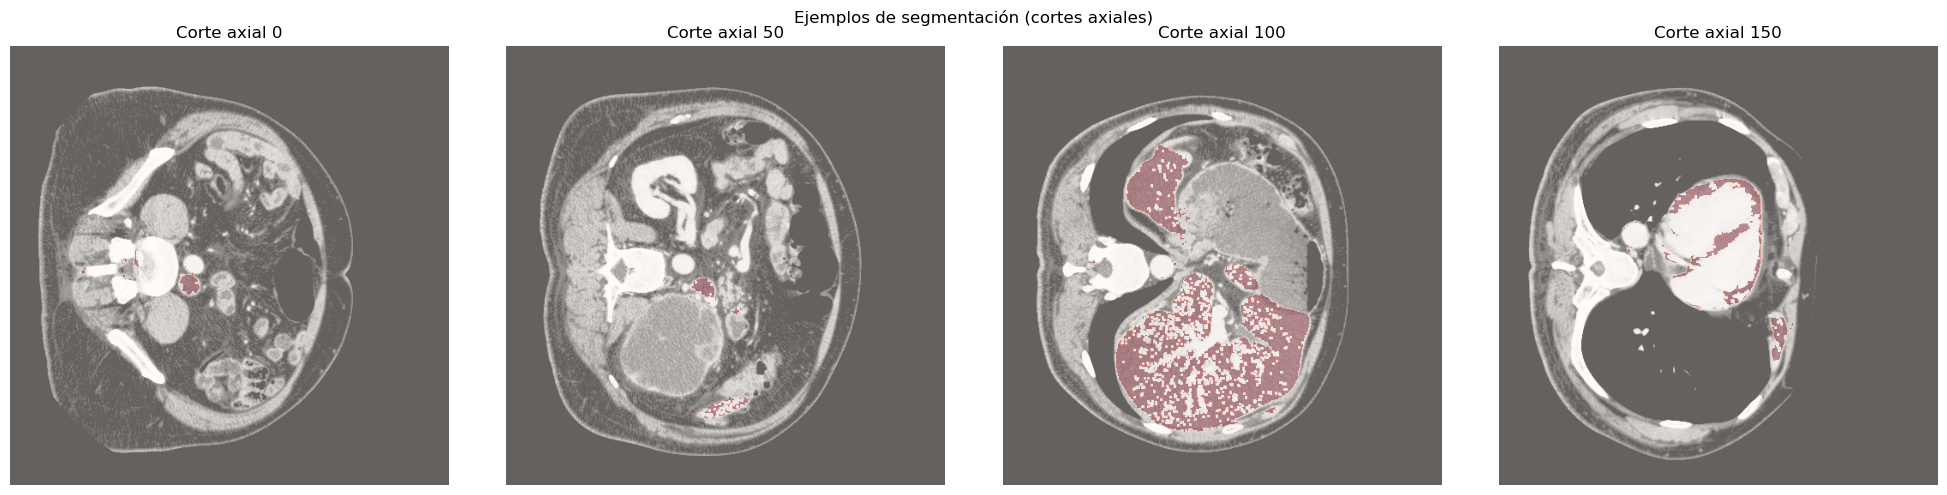

In [270]:

print(f"mean_jaccard final: {mean_jaccard:.3f}")

# --- Visualización: Subplot con al menos 4 cortes axiales ---
# Seleccionamos un volumen de ejemplo (por ejemplo, el primero)
vol_val_example = nib.load(vol_val_paths[0]).get_fdata()
seg_example = Segmentacion(vol_val_example)

# Suponiendo que los cortes axiales están en la dimensión 2 (índice z)
num_slices = vol_val_example.shape[2]
# Elegimos 4 índices distribuidos uniformemente
slice_indices = np.linspace(0, num_slices - 1, 4, dtype=int)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, idx in zip(axs, slice_indices):
    # Mostrar la imagen original en escala de grises
    ax.imshow(vol_val_example[:, :, idx], cmap='gray')
    # Superponer la segmentación en rojo con transparencia
    ax.imshow(seg_example[:, :, idx], cmap='Reds', alpha=0.4)
    ax.set_title(f'Corte axial {idx}')
    ax.axis('off')

plt.suptitle("Ejemplos de segmentación (cortes axiales)")
plt.tight_layout()
plt.show()


In [273]:
mean_jaccard = 0.0
vol_test_paths = glob(os.path.join('DB','test','volume_*.nii.gz'))
seg_test_paths = glob(os.path.join('DB','test','segmentation_*.nii.gz'))
pbar = tqdm(total=len(vol_test_paths))
for i, (vol_test_path, seg_test_path) in enumerate(zip(vol_test_paths, seg_test_paths), start=1):
    vol_test = nib.load(vol_test_path).get_fdata()
    seg_test = nib.load(seg_test_path).get_fdata()
    seg_total = Segmentacion(vol_test)
    jaccard_test = Jaccard_3D(seg_total,seg_test)
    mean_jaccard += (jaccard_test - mean_jaccard) / i
    pbar.update(1)
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [15:16<00:00, 305.40s/it]


mean_jaccard final: 0.290


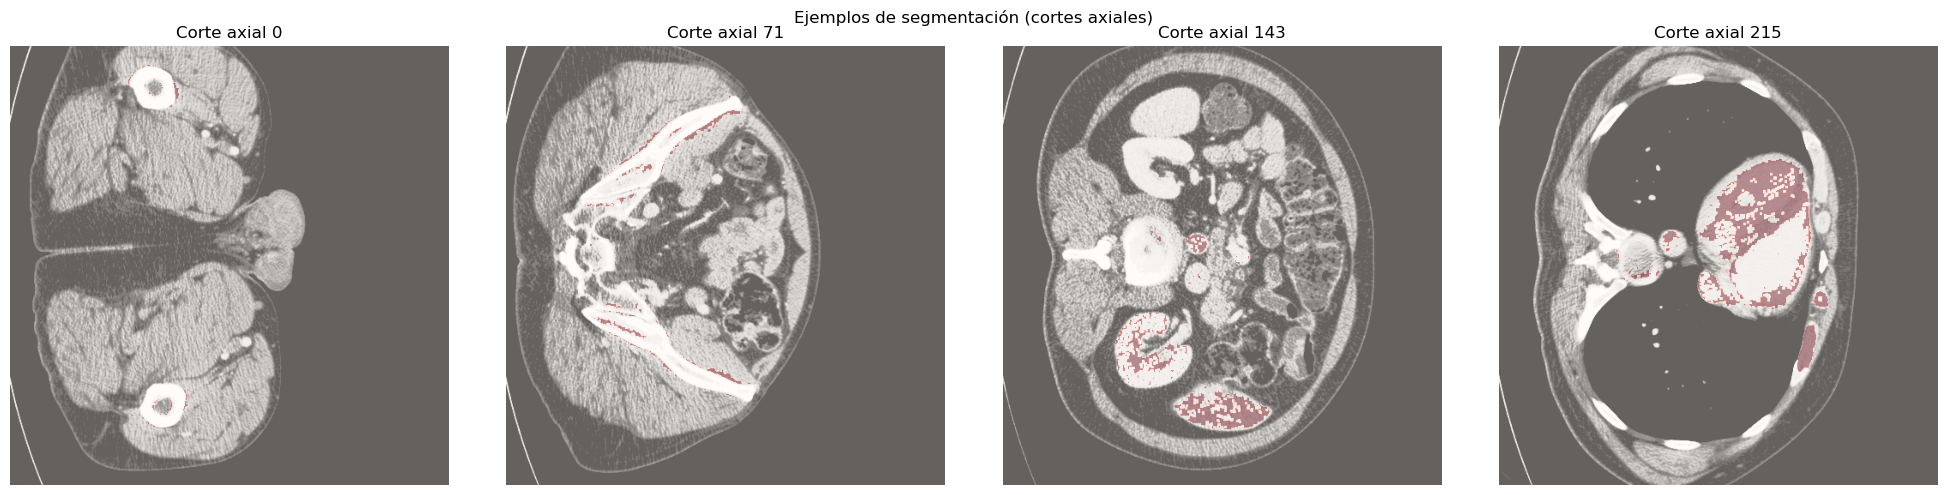

In [277]:
print(f"mean_jaccard final: {mean_jaccard:.3f}")
# --- Visualización: Subplot con al menos 4 cortes axiales ---
# Seleccionamos un volumen de ejemplo (por ejemplo, el primero)
vol_val_example = nib.load(vol_test_paths[0]).get_fdata()
seg_example = Segmentacion(vol_val_example)

# Suponiendo que los cortes axiales están en la dimensión 2 (índice z)
num_slices = vol_val_example.shape[2]
# Elegimos 4 índices distribuidos uniformemente
slice_indices = np.linspace(0, num_slices - 1, 4, dtype=int)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, idx in zip(axs, slice_indices):
    # Mostrar la imagen original en escala de grises
    ax.imshow(vol_val_example[:, :, idx], cmap='gray')
    # Superponer la segmentación en rojo con transparencia
    ax.imshow(seg_example[:, :, idx], cmap='Reds', alpha=0.4)
    ax.set_title(f'Corte axial {idx}')
    ax.axis('off')

plt.suptitle("Ejemplos de segmentación (cortes axiales)")
plt.tight_layout()
plt.show()
